In [201]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ApiClient
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
client = ApiClient()

In [79]:
client.create(
    [
        client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image}",
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="What's in this image?",
            img="https://cdn.midjourney.com/ca13f713-b289-45ee-92fe-b1276a1dc833/0_3.webp",
        ),
    ],
    format=JSON_MODE,
)

'{\n  "description": "The image features a female animated character with vibrant red hair and striking blue eyes. She is wearing a black bikini and is posed with her arms raised, hands behind her head, against a soft blue background.",\n  "style": "The artwork is rendered in a detailed digital painting style, characterized by smooth shading, detailed hair texturing, and a vivid color palette."\n}'

In [80]:
plt.plot(np.sin(np.array(range(300)) * 0.1))

client.create(
    [
        client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image}",
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="What's in this image?",
            img=plt,
        ),
    ],
    format=JSON_MODE,
)

'{"description": "The image displays a sine wave graph with five complete cycles stretching across a grid. The x-axis ranges from 0 to just over 300, and the y-axis ranges from -1.00 to 1.00. The wave oscillates smoothly between these y-values, demonstrating typical wave behavior.", "style": "Simplistic and educational, primarily used for illustrating mathematical concepts such as waves and oscillations."}'

In [206]:
day_history = get_day_history("TON")
week_history = get_week_history("TON")

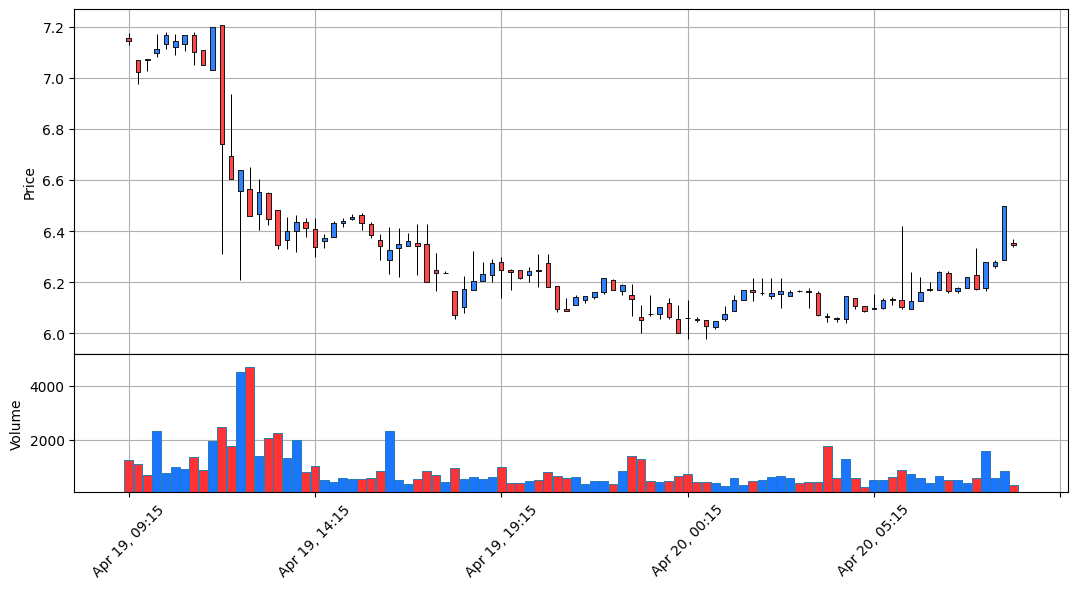

In [207]:
make_candlebars(day_history)

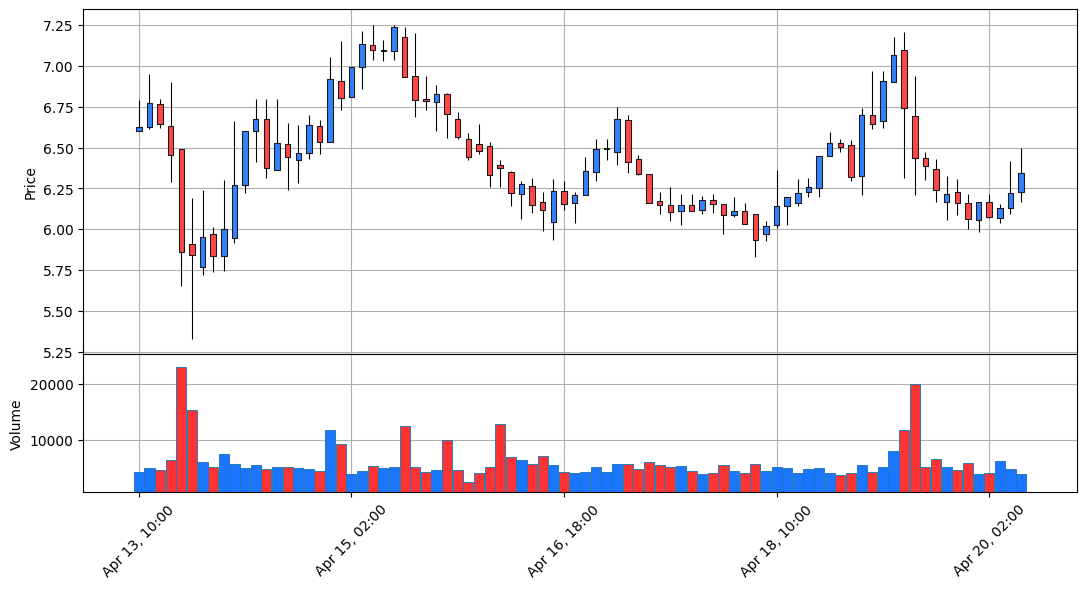

In [208]:
make_candlebars(week_history)

In [213]:
day_buf = make_candlebars(day_history, useBuf=True)
week_buf = make_candlebars(week_history, useBuf=True)

response = client.create(
    [
        client.make_msg(
            """You are professional trader.
            You have deep knowledge of cryptocurrencies and trading markets, and you can maximize profits the most efficiently.
            You trade in USDT.
            
            Respond with json of this format: 
            {
                'description': what you see on charts, general short and long term trends, 
                'trend_analysys': rough prediction of near future development of coin,
                'techical_analysys': visual technical analysis of plot and indicators,
                'optimal_strategy": optimal trading strategy to maximize profits in this situation,
                'final_decision': what to do, possible variants: 'sell', 'buy', 'hold' (do nothing),
                'amount': amount to byu or sell, 0 if action is 'hold'
            }
            """,
            role=ROLE_SYSTEM,
        ),
        client.make_msg(
            text="This is price history of this coin in the last day",
            img=day_buf,
        ),
        client.make_msg(
            text="This is price history of this coin in the last week",
            img=week_buf,
        ),
        client.make_msg(
            text="""
            This is price charts of TON coin, you need to come up with optimal strategy at this moment.
            Permorm price and signal analisys of this graph of this crypto coin.
            
            you current funds:
            {
                TON: 34.73,
                USDT: 56.14
            }
            """,
        ),
    ],
    format=JSON_MODE,
)
response

c:\Python312\Lib\site-packages\matplotlib\transforms.py:197: RuntimeWarning: coroutine 'bar' was never awaited
  ref = weakref.ref(


In [ ]:
json.load(response)